Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for.

## Part 1 - Exploratory Data Analysis

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# Load json file into DataFrame
file_path = './data/logins.json'
logins_df = pd.read_json(file_path).set_index('login_time')
logins_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


DataFrame is converted to index of type datetime for better and easier manipulation

In [3]:
# Get some information about the dataset
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Empty DataFrame


We have 93,143 login information. The date ranges from 01-01-1970 until 04-14-1970

In [4]:
# Check for NaN values
logins_df.isna().sum()

Series([], dtype: float64)

We did not find any NaN values on the DataFrame. 

In [5]:
# Get max and minimum dates
max_date = logins_df.index.max()
min_date = logins_df.index.min()

print(f'Oldest login:\t{min_date}')
print(f'Most recent:\t{max_date}')

Oldest login:	1970-01-01 20:12:16
Most recent:	1970-04-13 18:57:38


Let's add a column called `logins` so it is easier to count the number of logins per time interval

In [6]:
# Set a value of 1 to aggregate index column.
logins_df['logins'] = 1

In [7]:
# Resample to 15 minute time intervals and count logins
resampled_logins = logins_df.resample('15T').count() # minutely frequency
resampled_logins

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


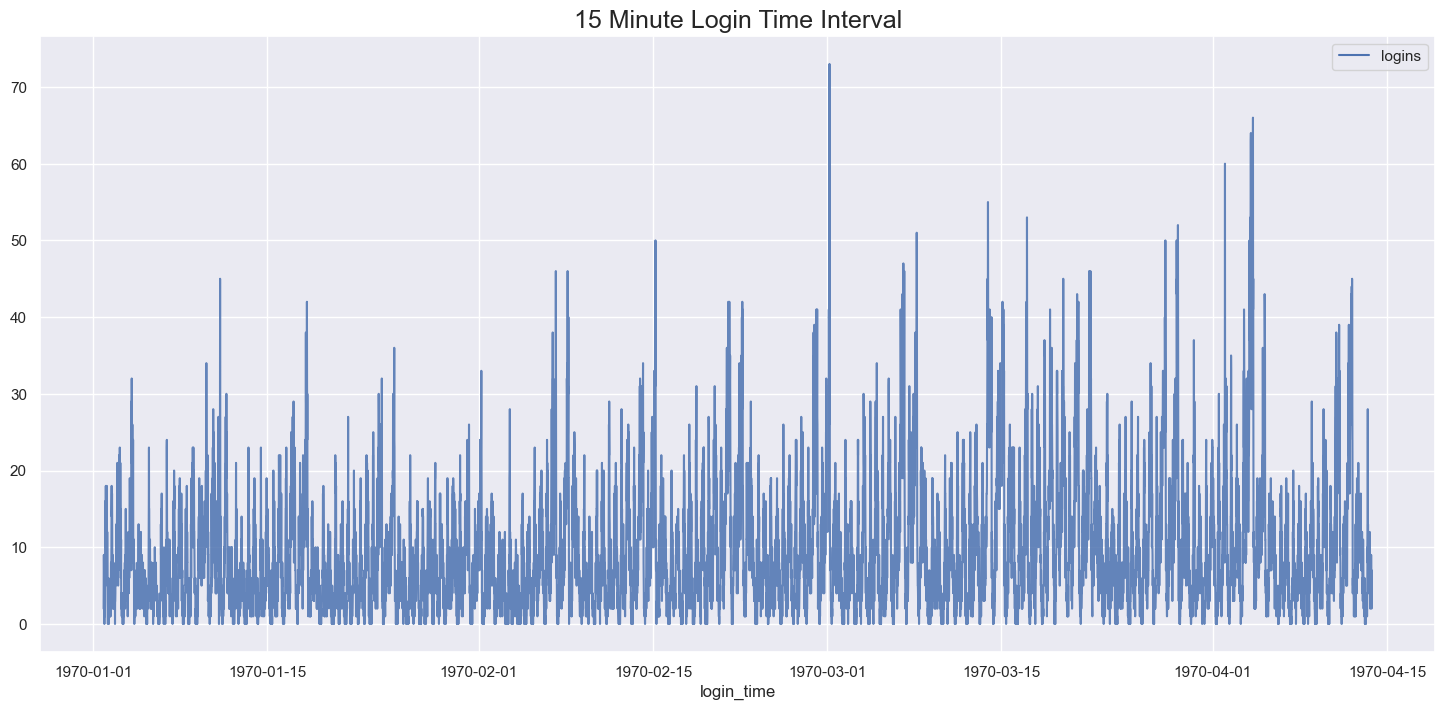

In [8]:
# Visualize login_time
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(18, 8)})
sns.lineplot(data=resampled_logins, alpha=0.85)
plt.title('15 Minute Login Time Interval', fontsize=18)
plt.show()

We can see here that the concentration of data points follows a sinusoidal pattern. 

In [9]:
# Extract day and month from login_time
resampled_logins['month'] = resampled_logins.index.month
resampled_logins['day'] = resampled_logins.index.day
resampled_logins['day_of_week'] = resampled_logins.index.day_of_week # Monday = 0, Sunday = 6
resampled_logins.sample(10)

,logins,month,day,day_of_week
login_time,,,,
1970-04-11 07:15:00,2,4,11,5
1970-03-05 21:45:00,19,3,5,3
1970-03-12 21:00:00,17,3,12,3
1970-02-07 16:30:00,8,2,7,5
1970-02-21 18:15:00,10,2,21,5
1970-04-05 05:30:00,11,4,5,6
1970-01-25 16:30:00,5,1,25,6
1970-02-24 11:30:00,18,2,24,1
1970-02-23 14:45:00,6,2,23,0


In [10]:
resampled_logins.describe()

,logins,month,day,day_of_week
count,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,2.259093,14.569268,3.035554
std,8.328818,1.017219,8.683342,2.012722
min,0.000000,1.000000,1.000000,0.000000
25%,3.000000,1.000000,7.000000,1.000000
50%,7.000000,2.000000,14.000000,3.000000
75%,13.000000,3.000000,22.000000,5.000000
max,73.000000,4.000000,31.000000,6.000000


We can notice outliers on the number of logins. Let's analyze the data above 99% percentile 

In [11]:
# Get the value where 99% of data lies below
percentile_99 = np.quantile(resampled_logins['logins'], 0.99)
df_99 = resampled_logins.loc[resampled_logins['logins'] > percentile_99]
print(f'99th Percentile:\t{percentile_99}')
df_99['day_of_week'].value_counts().sort_index()


99th Percentile:	38.0


1     2
2     2
3     1
4    10
5    37
6    40
Name: day_of_week, dtype: int64

There is record of more than 38 logins per day, except for Sunday.

In [12]:
df_99.loc[df_99['logins'] == 73]

,logins,month,day,day_of_week
login_time,,,,
1970-03-01 04:30:00,73,3,1,6


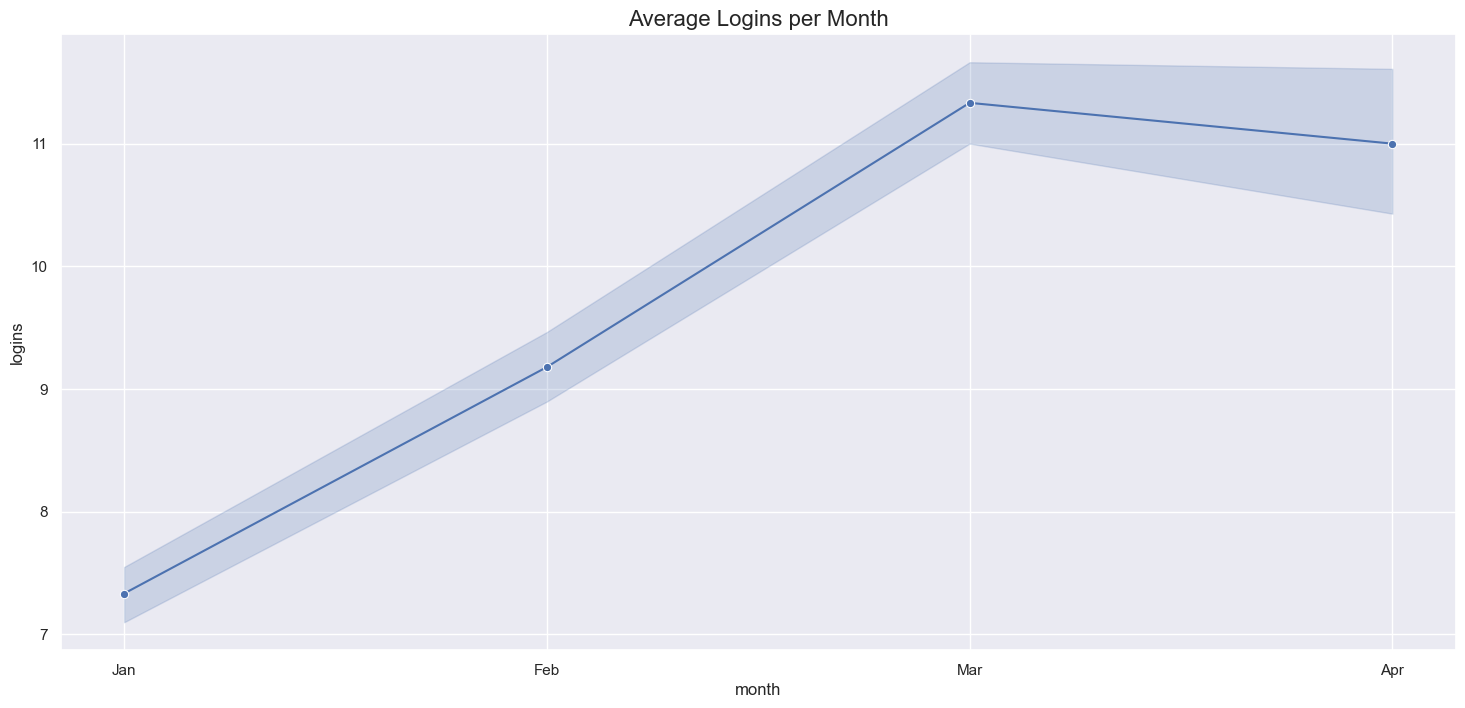

In [13]:
# Visualize average of logins per month.
sns.lineplot(data=resampled_logins, x='month', y='logins',
            markers=True, marker='o')
plt.title('Average Logins per Month', fontsize=16)
ax = plt.gca()
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr']) 
plt.show()

We can see that the amount of logins has increase from January to April. March being the month with more logins.

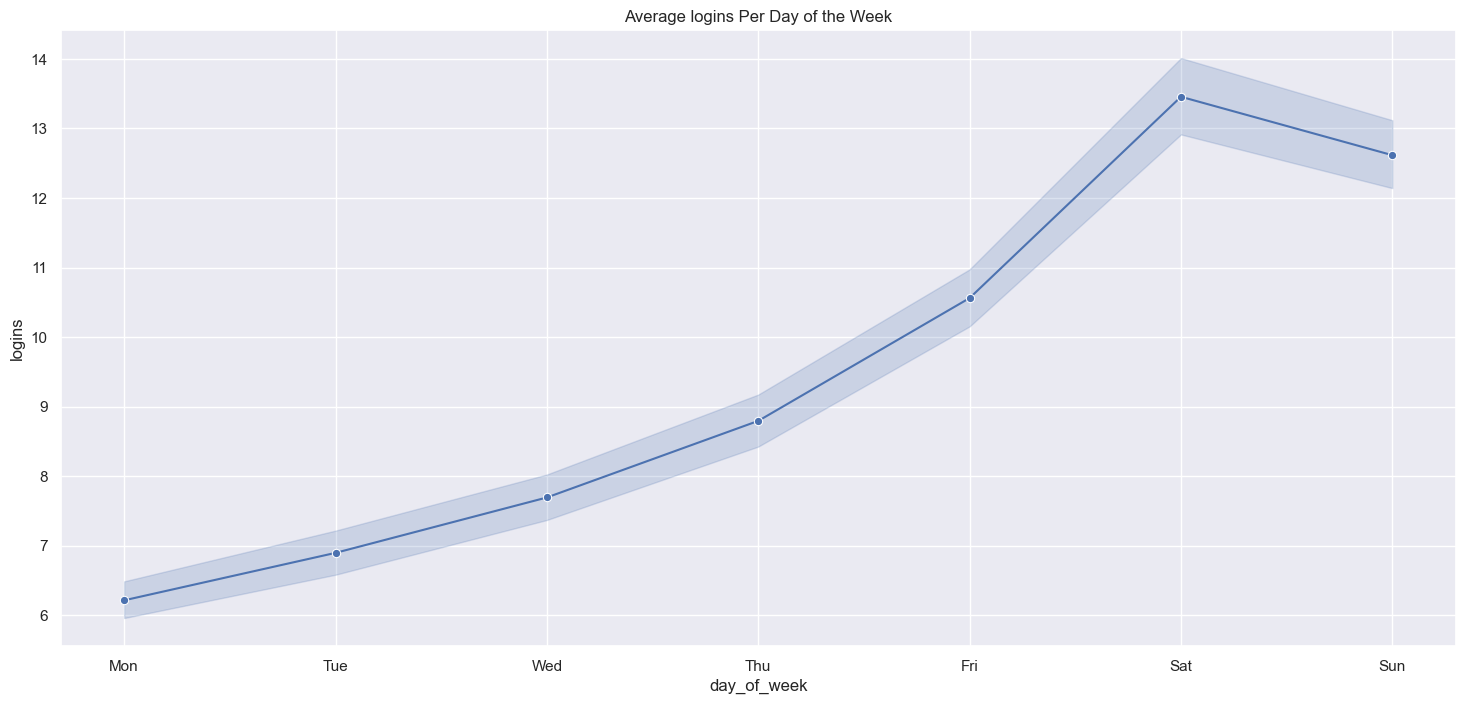

In [14]:
# Visualize 
sns.lineplot(data=resampled_logins, x='day_of_week', y='logins', 
            markers=True, marker='o')
ax = plt.gca()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average logins Per Day of the Week')
plt.show()

We can say that the days with most logins are the weekends which makes sense beaucase people have more free time on weekends.

As we see that Saturday is the dat with the most logins, Let's dig a little further.

Let's examine the date with daily frequency

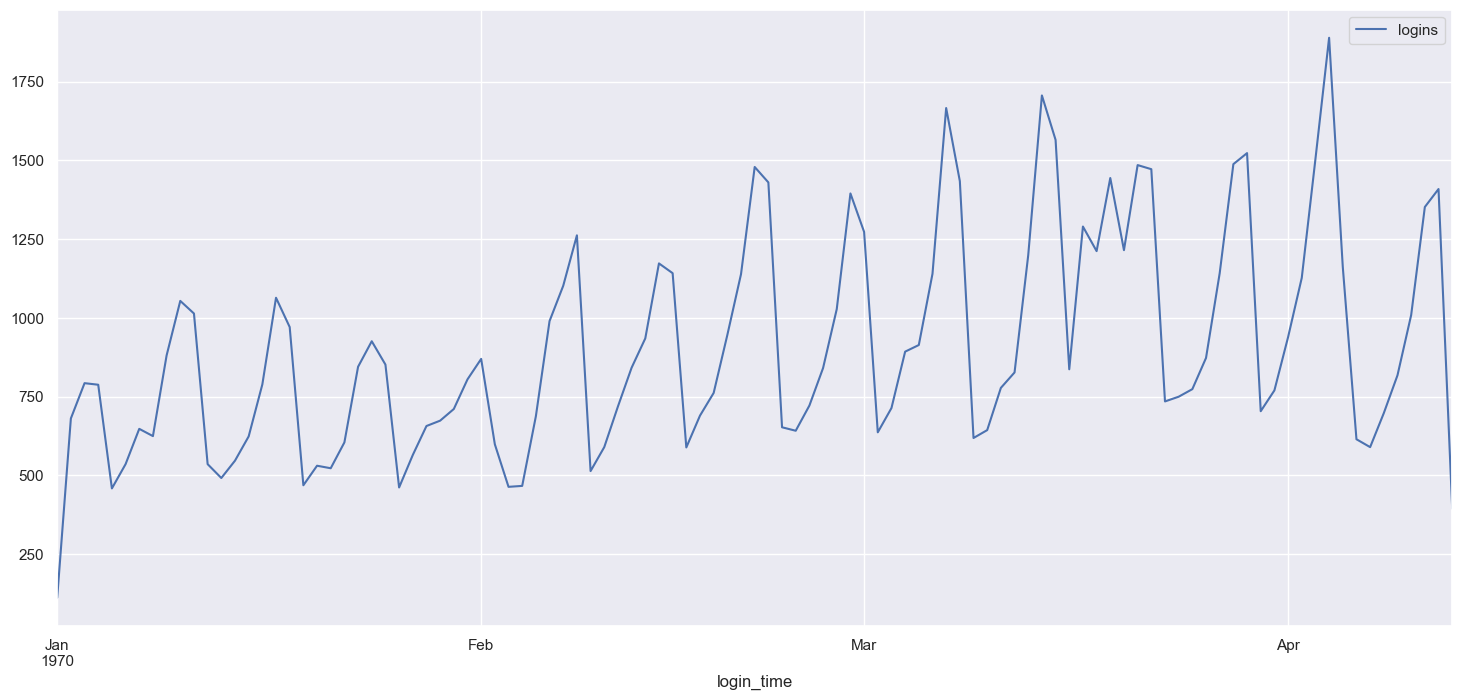

In [15]:
# Daily resample of data
ax = logins_df.resample(rule='D').count().plot()

The spikes represent weekends.

## Part 2 - Experiment and metrics design

Gotham
Metropolis

Gotham most active at night
Metropolis most active during the day

Weekends both cities

two way toll.
driver partners available in both cities ; reimbursing all toll costs

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Gotham and Metropolis have complementary circadian rhythms. So, we first need to ask if there is more demand for drivers in each city outside the activation time of the day. Assuming drivers from one city after active hours are willing to be available in the other city and do not need rest, the key measure of success will be an increase in the number of active drivers in each city while active hours.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.
We are going to focus on the weekends because on those days both cities are reasonably active. The best way to track driving partners serving both cities is by tracking their location. We can track their initial location and then every city that they have been available. 

To prove this experiment we can use a parametric statistical test along with a Z-test. We define the null and alternative hypotheses:
Ho: There is no change in population activity
Ha: There is a change in population activity (active in both cities)
The activity is reflected by the time each driver spends in each city. 


If we get to reject the Ho, we can say that reimbursing toll costs is making drivers active in both cities during the weekend, but this does not mean that both cities are not losing money by reimbursing toll costs. 


## Part 3 - Predictive Modeling

- Goal: Predict rider retention
- Data: Cohort of users signed up in January 2014
- User is considered __retained__ if they were "active" in the preceding (come before) 30 days
- Question: What factors are the best predictors for retention?

### EDA

In [16]:
# Load JSON file
file_path = './data/ultimate_data_challenge.json'
# Convert dates columns to datetime dtype
dataset = pd.read_json(file_path, convert_dates=['signup_date', 'last_trip_date'])

In [17]:
# Preview dataset
dataset.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [18]:
# Shape of DataFrame
print(f'Shape of dataset: {dataset.shape}')

Shape of dataset: (50000, 12)


In [19]:
# Print info of DataFrame
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

We see that all dtypes are correct for each feature.

In [20]:
# Create `active` column
# We consider a user retained if they were "active" in the preceding 30 days.
# We assume the most recent date is the last trip date.
most_recent = max(dataset['last_trip_date'])
print(f'Most recent date:\t{most_recent}')

# Substract 30 days from the most recent trip and assign retention status. 
dataset['retained'] = (most_recent - dataset['last_trip_date']).dt.days.astype(int)
dataset['retained'] = dataset['retained'].apply(lambda x: 1 if x <= 30 else 0)
dataset.head()

Most recent date:	2014-07-01 00:00:00


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [21]:
# Fraction of observed useres retained
print(f"Fraction of the observed users that were retained: {dataset['retained'].mean() * 100:.2f} %")

Fraction of the observed users that were retained: 37.61 %


Let's group aggregate `trips_in_first_30_day` with `city` to see which city has more trips

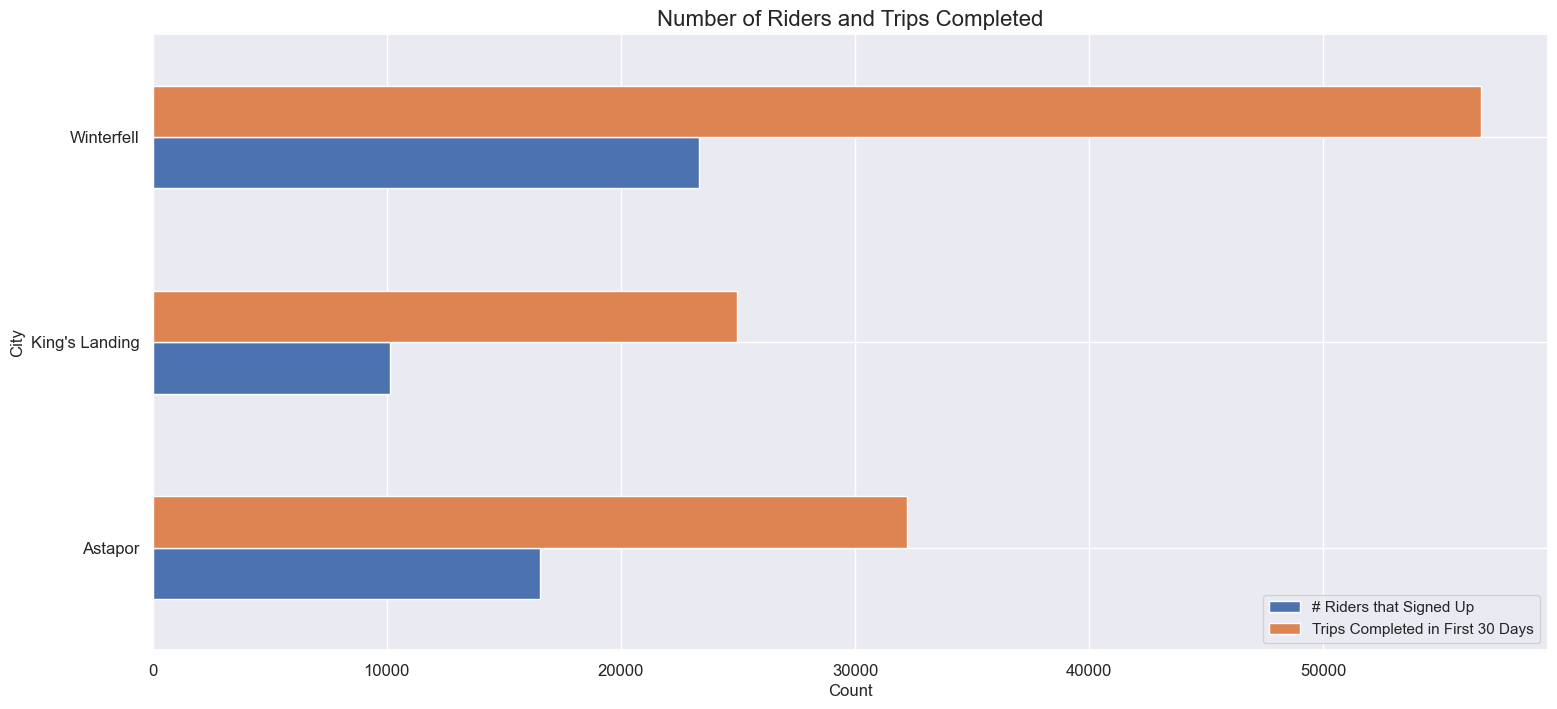

In [22]:
# Extract riders that signed up to the app and trips in 30 days
riders_and_trips = dataset.groupby(by='city').agg({'trips_in_first_30_days': ['count', 'sum']})
riders_and_trips.plot(kind='barh', xlabel='Count', ylabel='City', fontsize=12)
plt.legend(['# Riders that Signed Up', 'Trips Completed in First 30 Days'])
plt.title('Number of Riders and Trips Completed', fontsize=16)
plt.show()

From this graph, We can see that the less popular city is King's Landing with less than half of trips completed by Winterfell. It also has less customers.

Let's look at the outliers

In [23]:
dataset.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


We can see possible outliers in `trips_in_first_30_days` and `avg_dist`.

In [24]:
def remove_outliers(predictor):
    """
    Function to remove outliers using the common value for the factor k = 1.5
    """
    predictor_length = len(predictor)
    q_25, q_75 = np.percentile(predictor, 25), np.percentile(predictor, 75)
    iqr = q_75 - q_25
    print(f'25th: {q_25}\t75th: {q_75}\tIQR: {iqr}')
    cut_off = iqr * 1.5
    lower, upper = q_25 - cut_off, q_75 + cut_off
    print(f'Lower limit:\t{lower}\nUpper limit:\t{upper}')
    outliers_removed = predictor.loc[(predictor >= lower) & (predictor <= upper)]
    print(f'Identified outliers:\t{predictor_length - len(outliers_removed)}')
    print(f'Without outliers:\t{len(outliers_removed)}')
    return outliers_removed

25th: 2.42	75th: 6.94	IQR: 4.5200000000000005
Lower limit:	-4.360000000000001
Upper limit:	13.720000000000002
Identified outliers:	4494
Without outliers:	45506


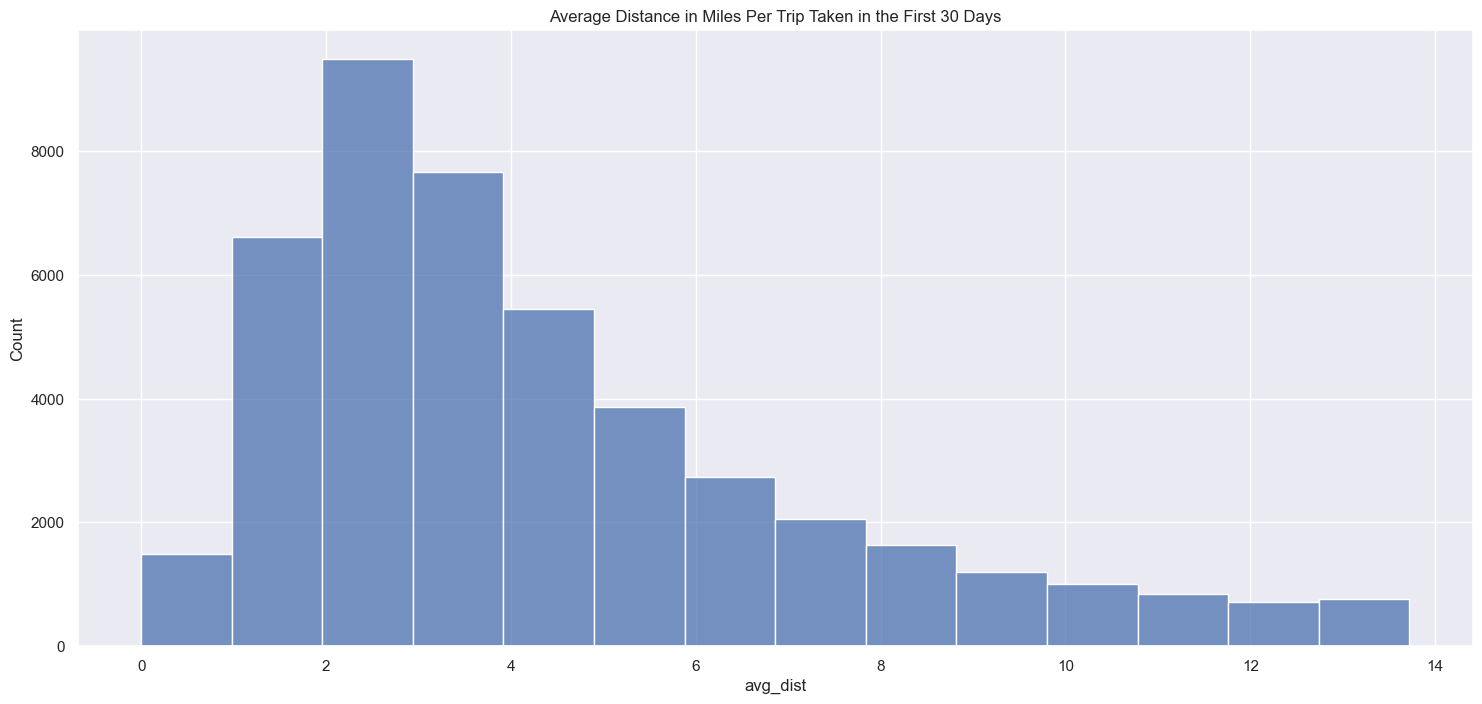

In [25]:
sns.histplot(data=remove_outliers(dataset['avg_dist']), bins=14)
plt.title(label='Average Distance in Miles Per Trip Taken in the First 30 Days')
plt.show()

We see here that most of the trips are one to four miles on average.

25th: 0.0	75th: 3.0	IQR: 3.0
Lower limit:	-4.5
Upper limit:	7.5
Identified outliers:	3181
Without outliers:	46819


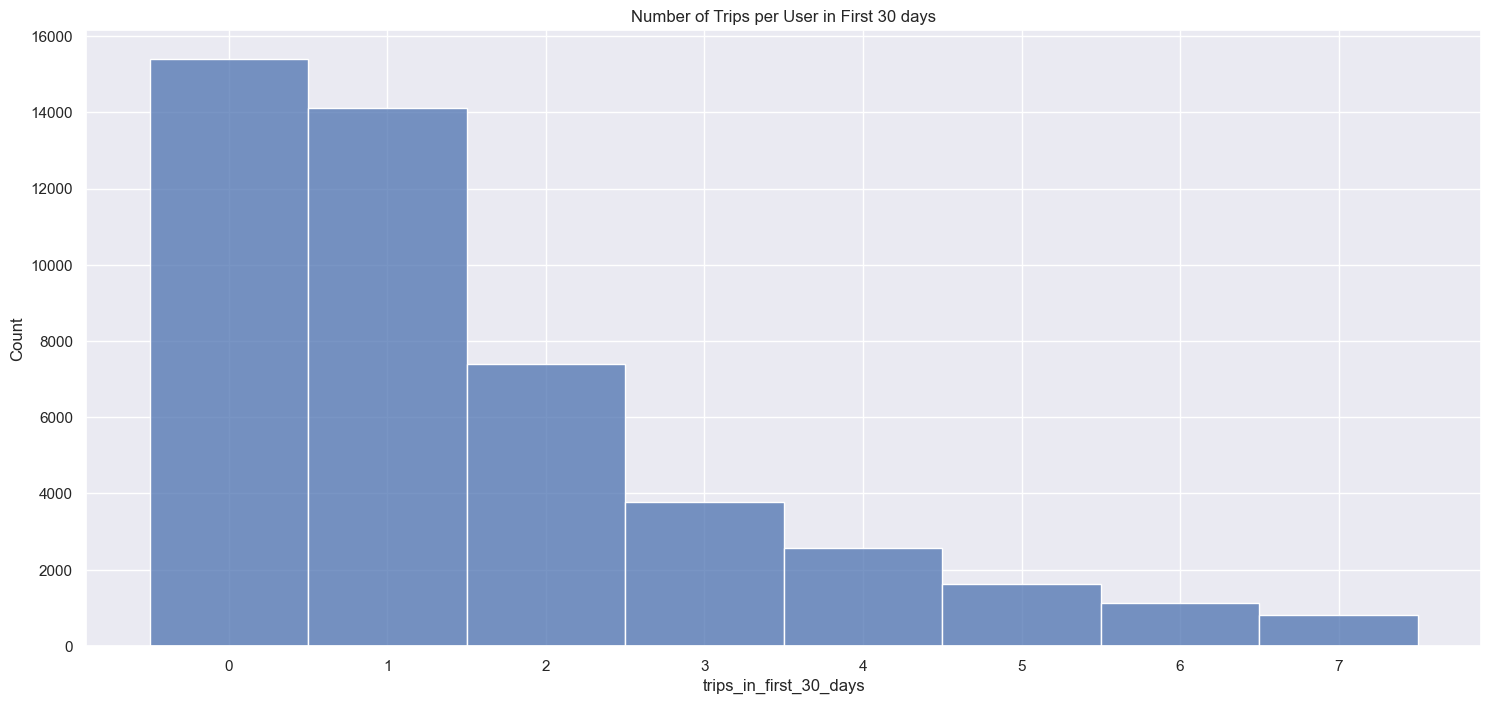

In [26]:
sns.histplot(data=remove_outliers(dataset['trips_in_first_30_days']), discrete=True)
plt.title(label='Number of Trips per User in First 30 days')
plt.show()

Same here, we see that the majority of riders just take one trip during the firs 30 days after signing up. 

Finally, Let's explore which city retains more riders

city            retained
Astapor         0           12306
                1            4228
King's Landing  0            3767
                1            6363
Winterfell      0           15123
                1            8213
Name: retained, dtype: int64


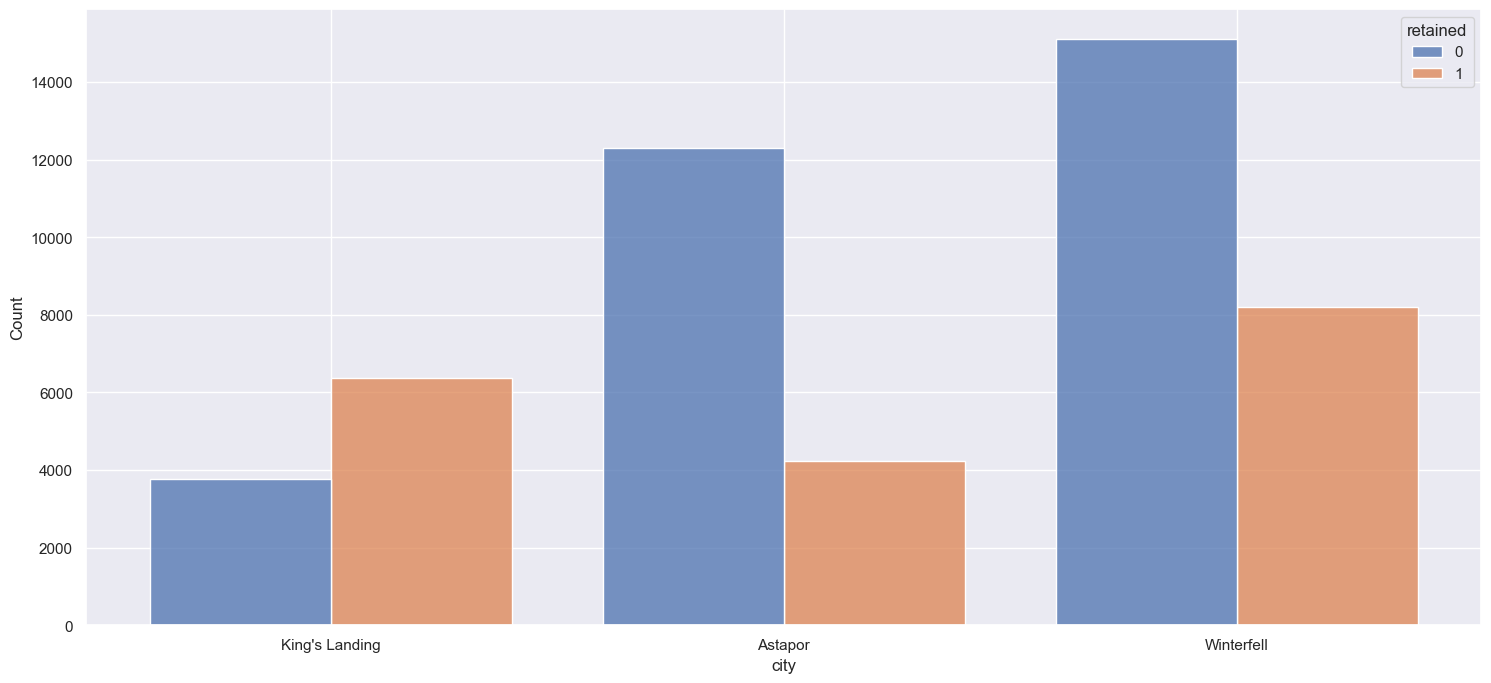

In [27]:
sns.histplot(data=dataset, x='city', hue='retained', shrink=0.8, multiple='dodge')
print(dataset.groupby(by='city')['retained'].value_counts().sort_index())

Here, we can notice that King's Landing is the only city where customers are more loyal to the service. 

### Pre-Processing and Training Data Development

We already can see that there are missing values on `phone`, `avg_rating_of_driver`, and `avg_rating_by_driver`.

In [28]:
no_out_dis = remove_outliers(dataset['avg_dist']).index.values.tolist()
no_out_trips = remove_outliers(dataset['trips_in_first_30_days']).index.values.tolist()

25th: 2.42	75th: 6.94	IQR: 4.5200000000000005
Lower limit:	-4.360000000000001
Upper limit:	13.720000000000002
Identified outliers:	4494
Without outliers:	45506
25th: 0.0	75th: 3.0	IQR: 3.0
Lower limit:	-4.5
Upper limit:	7.5
Identified outliers:	3181
Without outliers:	46819


This new dataframe does not include outliers.

In [29]:
no_outliers_df = dataset.loc[list(set(no_out_dis).intersection(no_out_trips))]
# Map bool values to int
no_outliers_df['ultimate_black_user'] =  no_outliers_df['ultimate_black_user'].astype(int)

In [30]:

nan_df = pd.concat([no_outliers_df.isna().sum().sort_values(ascending=False), no_outliers_df.isna().mean()], axis=1)
nan_df.columns = ['Sum', 'Percentage']
nan_df

,Sum,Percentage
avg_rating_of_driver,6655,0.157161
phone,319,0.007533
avg_rating_by_driver,181,0.004274
city,0,0.000000
trips_in_first_30_days,0,0.000000
signup_date,0,0.000000
avg_surge,0,0.000000
last_trip_date,0,0.000000
surge_pct,0,0.000000
ultimate_black_user,0,0.000000


In [31]:
# Drop NaN values from `Phone` column assuming that customers without a phone cannot book a ride.
dataset.dropna(subset=['phone'], axis=0, inplace=True)

In [32]:
# Calculate mean of rating_of_driver and avg_rating_by_driver
mean_of_driver = no_outliers_df['avg_rating_of_driver'].mean()
mean_by_driver = no_outliers_df['avg_rating_by_driver'].mean()

# Fill NaN values with their respective means
no_outliers_df['avg_rating_of_driver'].fillna(value=mean_of_driver, inplace=True)
no_outliers_df['avg_rating_by_driver'].fillna(value=mean_by_driver, inplace=True)

In [33]:
# Extract categorial and numerical features
cat_features = no_outliers_df.select_dtypes(include=['object', 'bool'])
num_features = no_outliers_df.select_dtypes(include=['int64', 'float64'])

In [34]:
# Process categorical features
# One-hot encoding
cat_dummies_df = pd.get_dummies(cat_features)


In [35]:
# DataFrame to use for training
df = pd.concat([cat_dummies_df, num_features], axis=1, join='inner')

# Separate features and label
y = df['retained']
X = df.drop(columns=['retained'])

In [36]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

In [37]:
# Check shape of split
print(f'X_train:{X_train.shape}\ty_train:{y_train.shape}')
print(f'X_test: {X_test.shape}\ty_test: {y_test.shape}')

X_train:(33876, 13)	y_train:(33876,)
X_test: (8469, 13)	y_test: (8469,)


In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Modeling

Initialize binary classifiers

In [39]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=10000)

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC(max_iter=10000)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# Performance evaluation of each binary classifier
accuracy, precision, recall = {}, {}, {}

# Loop through models
for key in models.keys():
    # Fit classifier
    models[key].fit(X_train_scaled, y_train)

    # Make predictions
    predictions = models[key].predict(X_test_scaled)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/Users/rcepeda/opt/anaconda3/envs/data_science/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [40]:
# Create DataFrame with results
df_models = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_models['Accuracy'] = accuracy.values()
df_models['Precision'] = precision.values()
df_models['Recall'] = recall.values()
df_models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall
Random Forest,0.754398,0.645516,0.669352
K-Nearest Neighbor,0.733853,0.601813,0.644814
Logistic Regression,0.713662,0.457753,0.653420
Support Vector Machines,0.710355,0.435416,0.654820
Decision Trees,0.701618,0.586598,0.591770
Naive Bayes,0.683316,0.731305,0.549501


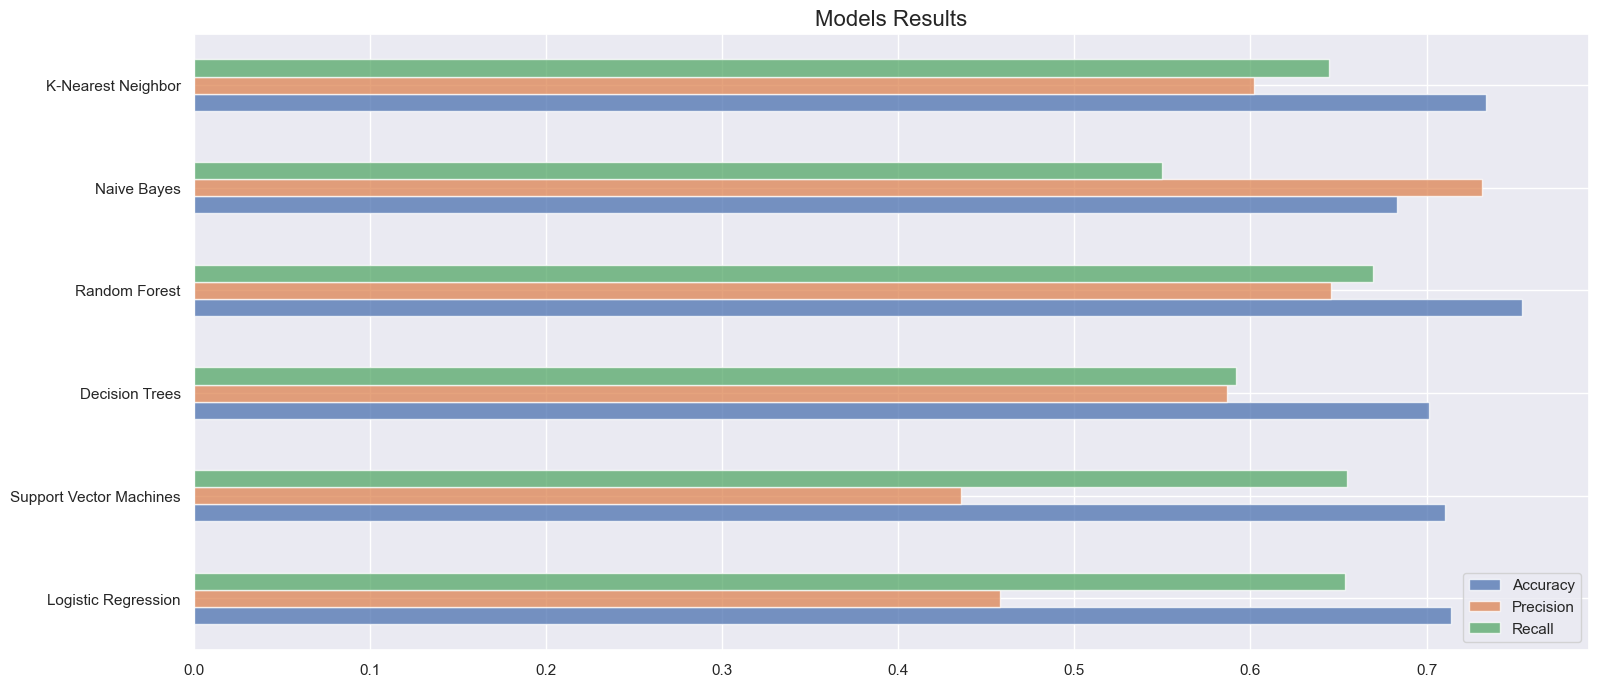

In [41]:
# Bar chart to compare the classifier's performance

ax = df_models.plot.barh(alpha=0.75)
plt.title('Models Results', fontsize=16)
plt.show()

Analyze wich factors influence the most

In [42]:
importances = models['Random Forest'].feature_importances_
feature_names = X_train.columns.values
rand_forest_importances = pd.Series(importances, index=feature_names)
rand_forest_importances.sort_values(ascending=False)

avg_dist                  0.303448
weekday_pct               0.138374
avg_rating_by_driver      0.118426
avg_rating_of_driver      0.085930
trips_in_first_30_days    0.070982
avg_surge                 0.068014
surge_pct                 0.067433
city_King's Landing       0.049556
ultimate_black_user       0.031950
phone_iPhone              0.020642
phone_Android             0.016956
city_Astapor              0.016182
city_Winterfell           0.012108
dtype: float64

Three features contribute the most to the model. These are the average distance in miles per trip taken in the first 30 days after signing up, the percentage of the user's trips occurring during a weekday, and the rider's average rating over all of their trips.

The most accurate predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system is `Random Forest` with a 75 % on unseen data. This is not perfect and could be improved with more data and hyperparameter tuning. We decide to move forward with Random Forest because it has also the highest precision and recall scores. Analyzing these three key features, Ultimate could try to improve some things for customer retention. For example, Ultimate could decrease the ride fare by a fraction if customer retention is more important than maximizing profitability. Next, Ultimate could offer some kind of incentive so that customers use the service more often during the first 30 days of signing up. Finally, Ultimate could find ways to better validate the ratings to riders. As these are the most influential features, better focusing on these three could certainly improve customer retention. 